# AI COM2028 COURSEWORK JUPYTER NOTEBOOK

#### Overview <br />
This coursework concerns the automated classification of images through machine learning techniques. You will work on bloodcell image data, where training samples and their
ground truth are provided. You will develop suitable classification techniques to classify
unseen examples, a poster to introduce the problem. You will need to submit a Jupyter
notebook containing your code for training and evaluation, your prediction outcome of the
test dataset, and a poster by 4pm on Wednesday 10th May. Any of your experiment figures
and/or tables included in your poster need to be reproducible in the Jupyter notebook that
you submit.

### Start by importing some relevant modules

In [88]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical


# Next load in the training data images (from local machine) <br />
# IF USING COLAB, SKIP NEXT TWO CELLS AND USE ONES AFTER IT 
We can do this using skimage.io <br />
We import the imread_collection and concatenate_images functions. <br />
These alllow us to read in the images from a given path, and then the concatenate_images function allows us to convert that collection to a numpy array

In [2]:
from skimage.io import imread
from skimage.io import imread_collection, concatenate_images

#set file path for local training images
training_images_path = './COM2028_2023/train'

#imread_collection allows us to load folder of images into an array
training_images_collection = imread_collection(training_images_path + '/*.jpg')
training_images = np.concatenate([image[np.newaxis] for image in training_images_collection])
print(type(training_images))



<class 'numpy.ndarray'>


# Now we load in the ground truths (from local machine)


In [89]:
train_groundtruth_path = './COM2028_2023/train.txt'
training_image_path_list = []

#since we are loading in text (strings) we can use pythons regular file reading functionallity
ground_truths = np.array([])

def linereader(line):
	values = line.split(' ') #each line contains path, value seperated by a space
	image_path = values[0]  #path is 1st value [0]
	truth = values[1]  #truth is 2nd value [1]
	truth= truth.strip('\n') #our value has a '\n' appended to it for file formatting, we remove this
	return truth, image_path


with open(train_groundtruth_path, 'r') as file:
	for line in file:
		truth, image_path = linereader(line)
		ground_truths = np.append(ground_truths, int(truth)) #we add the value to ground_truths array
		training_image_path_list.append(image_path)

	file.close()

#one hot encode the ground_truths to vectorise
ground_truths = to_categorical(ground_truths, num_classes=8)

# ONLY RUN CELL BELOW IF USING COLAB 
# THIS CELL HANDLES LOADING OF TRAINING DATA AND ITS ASSOCIATED LABELS


In [90]:
#ONLY USE IF USING COLAB
from google.colab import drive
drive.mount('/content/drive')
!unzip "drive/MyDrive/COM2028-2023.zip" -d "drive/MyDrive"


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from keras.preprocesing.image import ImageDataGenerator

image_path = '/content/drive/MyDrive/COM2028-2023/'

# Print out some example images from training set

In [ ]:
#print out some example training images
#print out 16 example training images using subplots(4,4), giving us 4 rows of 4 columns

for i in range(0,16):
    plt.subplot(4,4, i+1)
    plt.imshow(training_images[i])
    



# Relevance of colors <br />
The above images show three of the blood sample images. <br />
Given that the colors of the samples in all images are the same, we can reason that color is potentially meaningless in the process of classifying the images. <br />
We should instead focus on the 'shape' of the image, rather than the color. <br />
Because of this, we can convert our images to grayscale format. We do this by calculating a weighted sum of the R,G,B values of the images for each image. <br />
This is done below

In [ ]:
#formula for converting images from RGB to grayscale
#0.299 R + 0.587 G + 0.114 B

#declare an empty numpy array of dimension (1000,28,28) - to store
grayscale_training = np.empty((len(training_images),28,28), int)


for i in range(0,len(training_images)):

    image = training_images[i] 
    R = image[:,:,0] # [:] means all the points in that direction, in this case zero gets the 1st value (0) in
                    #the 3rd dimension, the 2 colons does this for all 256x256 pixels in the image
    G = image[:,:,1] #select green colors

    B = image[:, :, 2]
    gray = 0.299 * R +  0.587*G + 0.114*B

    grayscale_training[i] = gray

#now we print out grayscale images and their respective original versions


for i in range(0,4):
    if i<2:
        plt.subplot(2, 2,i+1)
        plt.imshow(grayscale_training[i], cmap = 'gray')
    else:
        plt.subplot(2,2, i+1)
        plt.imshow(training_images[i-2], cmap = 'gray')

grayscale_training = grayscale_training.reshape(10000,28, 28 ,1)



In [11]:
print(grayscale_training.shape)

(10000, 28, 28, 1)


# Splitting our training data into training and validation sets <br />
Since our test set is seperate from our training set, we only have to split the data into training/validation split <br />
We are not going to manually split up our dataset, and will instead use a parameter when calling model.fit() to split it for us automatically


In [81]:

print(grayscale_training.shape)
print(ground_truths.shape)


(10000, 28, 28, 1)
(10000, 8)


# Ground truth label values range from 0-7



# Type of classifier to use <br />
Since each target can belong to one of 8 classes, we know we need to use a multiclass classifier for our model. <br /> Binary classifier is not suitable here since that only works for samples that can belong to one of two classes. <br />


(28, 28, 3)


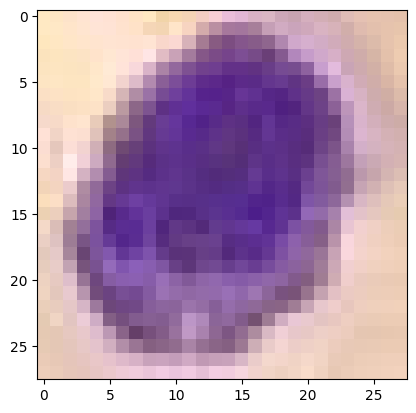

[255 233 195]
[ 86  46 143]


In [20]:
sample1 = training_images[0] #grabs the first training sample
print(sample1.shape)

plt.imshow(sample1)
plt.show()
#get top left pixel values
topleft_pixels = sample1[0][0]
print(topleft_pixels)
#then get ~middle pixe values
middle_pixels = sample1[14][14]
print(middle_pixels)

# Defining the model <br />
Now that we have gone over the shape of the data, and the relevance of the different pixel intensity values (RGB), we can actually define the model. <br />
As stated before, we want to use a multiclass classification algorithm as each blood sample should belong to one of the 8 classes (0-7). <br /> 
We will define our model using Tensorflow and Keras <br />
- We define a few of the hyperparameters such as learning rate, the optimizer we want to use and the loss function of choice
- Once these are defined, we then declare out model with Keras.Sequential()
- - Once we've done this we add various layers, generally in the order - convolutional -> pooling -> fully connected -> output layer




In [85]:
#Importing all libraries that are relevant to the creation and training of models
#Import relevant libraries
from keras.layers import Rescaling
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [ ]:

learning_rate = 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()
crossentropy = keras.losses.CategoricalCrossentropy()


model1 = keras.Sequential()
model1.add(Rescaling(1./255))
model1.add(Conv2D(32, kernel_size=(2,2), activation="relu", input_shape=(28,28,1)))
model1.add(Conv2D(64, kernel_size=(4,4), activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid"))
model1.add(Flatten())
model1.add(Dense(32, activation="relu"))
model1.add(Dense(8, activation="softmax"))

model1.compile(optimizer=optimizer, metrics = [accuracy], loss = crossentropy)


history = model1.fit(grayscale_training, ground_truths, validation_split=0.2, epochs=10, batch_size=32)# Access training loss
train_loss = history.history['loss']
print('Training Loss:', train_loss)
model1.summary()

## The above model performs very badly, there are various reasons for this such as:
= Low epoch number - Having too few epochs for the model can (and has above) resulted in sever underfitting. The model has not been able to learn the underlying patterns of the input images, and needs more iterations in order to do so. Out model is too simple and performs poorly on training and validation data, it would also perform badly on test data (although not shown above).
- Generally unoptimised parameters - As this is the first iteration of our Neural network, the hyperparameters are inevitably unoptimised, and our model is performing much worse than it necessarily could.
- There are numerous approached we can take in order to optimise the various hyperparameters in our model

## One very obvious (and simple change) is to increase the number of epochs.
Given the number of input images, and the spatial resolution of them, a good starting epoch number could be somewhere between 30-100, rather than the 10 used above
### We will start with running the same model, just with 40 epochs rather than 10. This will result in a longer training time but will hopefully help our model to 'learn' the training data more effectively

In [87]:

learning_rate = 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()
crossentropy = keras.losses.CategoricalCrossentropy()


model1 = keras.Sequential()
model1.add(Rescaling(1./255))
model1.add(Conv2D(32, kernel_size=(2,2), activation="relu", input_shape=(28,28,1)))
model1.add(Conv2D(64, kernel_size=(4,4), activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid"))
model1.add(Flatten())
model1.add(Dense(32, activation="relu"))
model1.add(Dense(8, activation="softmax"))

model1.compile(optimizer=optimizer, metrics = [accuracy], loss = crossentropy)


history = model1.fit(grayscale_training, ground_truths, validation_split=0.2, epochs=40, batch_size=32)# Access training loss
train_loss = history.history['loss']
print('Training Loss:', train_loss)
model1.summary()

Epoch 1/40
250/250 [==============================] - 29s 109ms/step - loss: 1.7618 - categorical_accuracy: 0.3453 - val_loss: 1.4659 - val_categorical_accuracy: 0.4485
Epoch 2/40
250/250 [==============================] - 26s 104ms/step - loss: 1.2190 - categorical_accuracy: 0.5531 - val_loss: 1.0939 - val_categorical_accuracy: 0.6205
Epoch 3/40
250/250 [==============================] - 26s 106ms/step - loss: 1.0608 - categorical_accuracy: 0.6110 - val_loss: 0.9878 - val_categorical_accuracy: 0.6740
Epoch 4/40
250/250 [==============================] - 26s 105ms/step - loss: 0.9985 - categorical_accuracy: 0.6366 - val_loss: 0.9529 - val_categorical_accuracy: 0.6885
Epoch 5/40
250/250 [==============================] - 26s 105ms/step - loss: 0.9496 - categorical_accuracy: 0.6604 - val_loss: 0.9381 - val_categorical_accuracy: 0.6865
Epoch 6/40
250/250 [==============================] - 26s 104ms/step - loss: 0.9344 - categorical_accuracy: 0.6647 - val_loss: 0.9158 - val_categorical_acc

KeyboardInterrupt: 

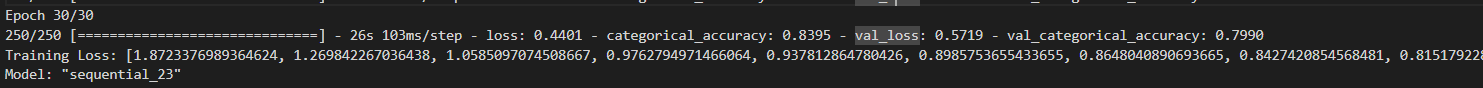
